# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [327]:
# student 1: Yarin 2822
# student 2: Shay 1405

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [455]:
#CELL1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

In [456]:
#CELL 2

# הגדרת נתיבי הקבצים של מערכי האימון והבדיקה
train_data_path = 'titanic_train.csv'  
test_data_path = 'titanic_test.csv'    

# טעינת הנתונים ממערכי ה-CSV לקבצי DataFrame של pandas
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

# בדיקה עבור ערכים חסרים בכל עמודה ויצירת DataFrame להצגה
missing_values = train_df.isnull().sum()
missing_values_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})

# ספירת מספר הכפילויות במערך הנתונים
duplicate_count = train_df.duplicated().sum()

# בדיקה של סוגי הנתונים בכל עמודה ויצירת DataFrame להצגה
data_types = train_df.dtypes
data_types_df = pd.DataFrame({'Column': data_types.index, 'Data Type': data_types.values})

# הדפסת תוצאות הבדיקה: ערכים חסרים, כפילויות וסוגי נתונים
print("\nMissing Values in Dataset:")
display(missing_values_df)

print(f"\nNumber of duplicate rows in the dataset: {duplicate_count}")

print("\nData Types of the columns:")
display(data_types_df)



Missing Values in Dataset:


,Column,Missing Values
0,Pclass,0
1,Sex,0
2,Age,0
3,SibSp,0
4,Parch,0
5,Fare,0
6,Embarked,0
7,Survived,0



Number of duplicate rows in the dataset: 80

Data Types of the columns:


,Column,Data Type
0,Pclass,int64
1,Sex,int64
2,Age,float64
3,SibSp,int64
4,Parch,int64
5,Fare,float64
6,Embarked,int64
7,Survived,int64


In [457]:
#CELL3
def remove_duplicates_inplace(df):
    """
    This function removes duplicate rows from the DataFrame in place.
    It also prints the number of duplicates found and removed.
    """
    
    duplicate_count_before = df.duplicated().sum()
    

    df.drop_duplicates(inplace=True)
    

    duplicate_count_after = df.duplicated().sum()
    

    print(f"Number of duplicate rows before removal: {duplicate_count_before}")
    print(f"Number of duplicate rows after removal: {duplicate_count_after}")
    print(f"Shape of the dataset after removing duplicates: {df.shape}")


In [397]:
#CELL4
remove_duplicates_inplace(train_df)


Number of duplicate rows before removal: 80
Number of duplicate rows after removal: 0
Shape of the dataset after removing duplicates: (632, 8)


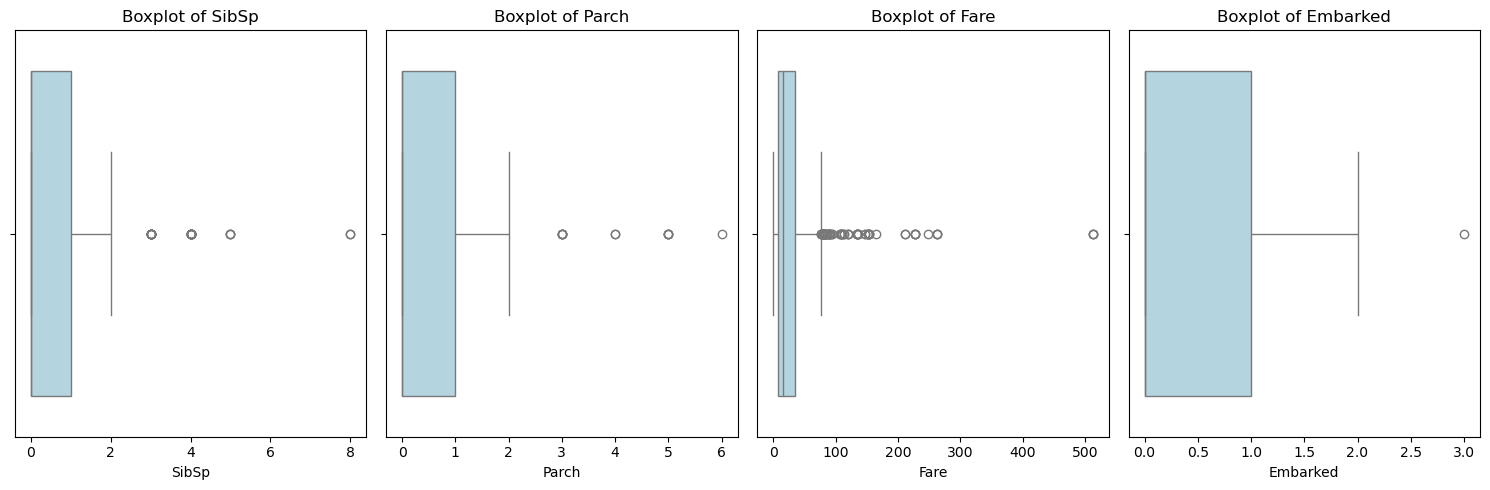

In [398]:
#CELL5
def plot_selected_outliers(df, selected_columns):
    """
    This function creates boxplots for the selected numerical columns in the DataFrame
    to visualize the outliers.
    """
    plt.figure(figsize=(15, 5))
    
    for i, col in enumerate(selected_columns, 1):
        plt.subplot(1, len(selected_columns), i)
        sns.boxplot(x=df[col], color='lightblue')
        plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()

selected_columns = ['SibSp', 'Parch', 'Fare', 'Embarked']

plot_selected_outliers(train_df, selected_columns)



In [399]:
# TIPUL 
#CELL6
def remove_selected_outliers(df, selected_columns):
    """
    This function removes outliers from the selected numerical columns in the DataFrame
    using the IQR method and returns the cleaned DataFrame.
    """
    for col in selected_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
      
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df


selected_columns = ['SibSp', 'Parch', 'Fare', 'Embarked']


train_df_cleaned = remove_selected_outliers(train_df, selected_columns)

print(f"Shape of the dataset after removing outliers: {train_df_cleaned.shape}")



Shape of the dataset after removing outliers: (305, 8)


In [400]:
#CELL7 ה5 שורות הראשונות מכל מערך
print("Train dataset - first 5 rows:")
print(train_df.head())

print("\nTest dataset - first 5 rows:")
print(test_df.head())

Train dataset - first 5 rows:
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0

Test dataset - first 5 rows:
   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1


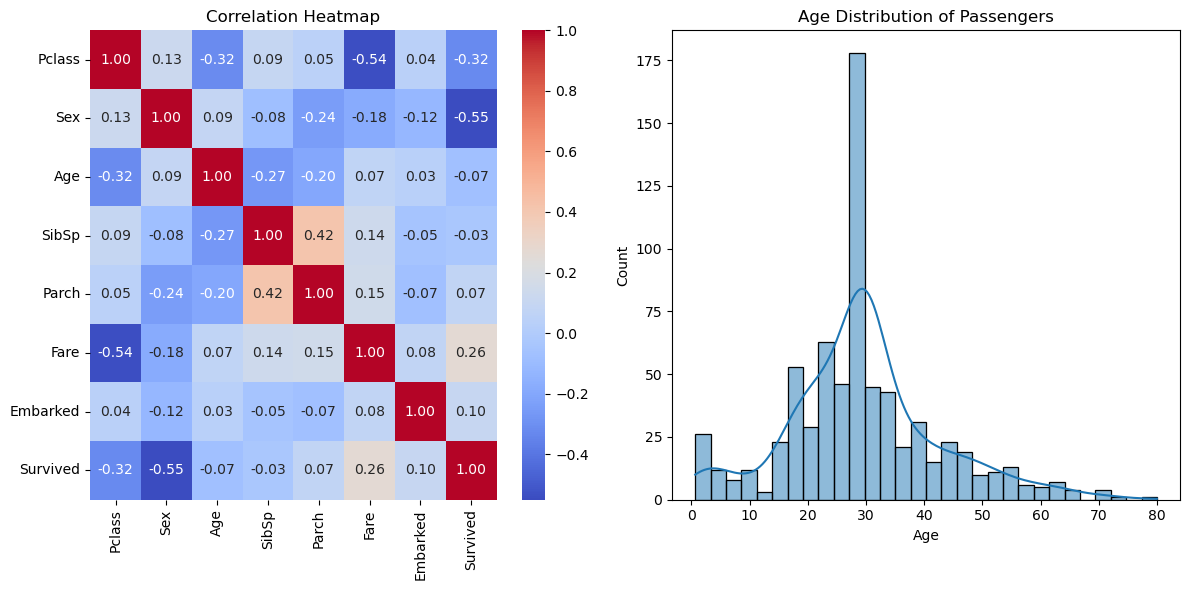

In [462]:
#CELL 9

# יצירת שטח ציור בגודל 12x6 אינץ'
plt.figure(figsize=(12, 6))

# יצירת גרף 1: מפת חום להצגת המתאמים בין משתנים מספריים בנתוני האימון
plt.subplot(1, 2, 1)
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")  # כותרת הגרף

# יצירת גרף 2: היסטוגרמה להצגת התפלגות הגילאים של הנוסעים
plt.subplot(1, 2, 2)
sns.histplot(train_df['Age'], bins=30, kde=True)  # kde=True מציג את צפיפות ההתפלגות
plt.title("Age Distribution of Passengers")  # כותרת הגרף

# התאמה אוטומטית של המרווחים בין הגרפים להצגה מסודרת
plt.tight_layout()
plt.show()  # הצגת הגרפים


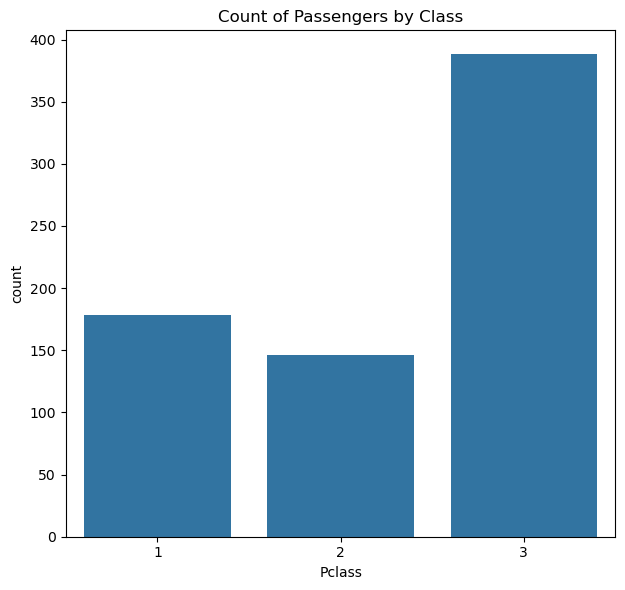

In [463]:
#CELL10 יצירת עוד ויזוליזאציה
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Pclass', data=train_df)
plt.title("Count of Passengers by Class")
plt.tight_layout()
plt.show()


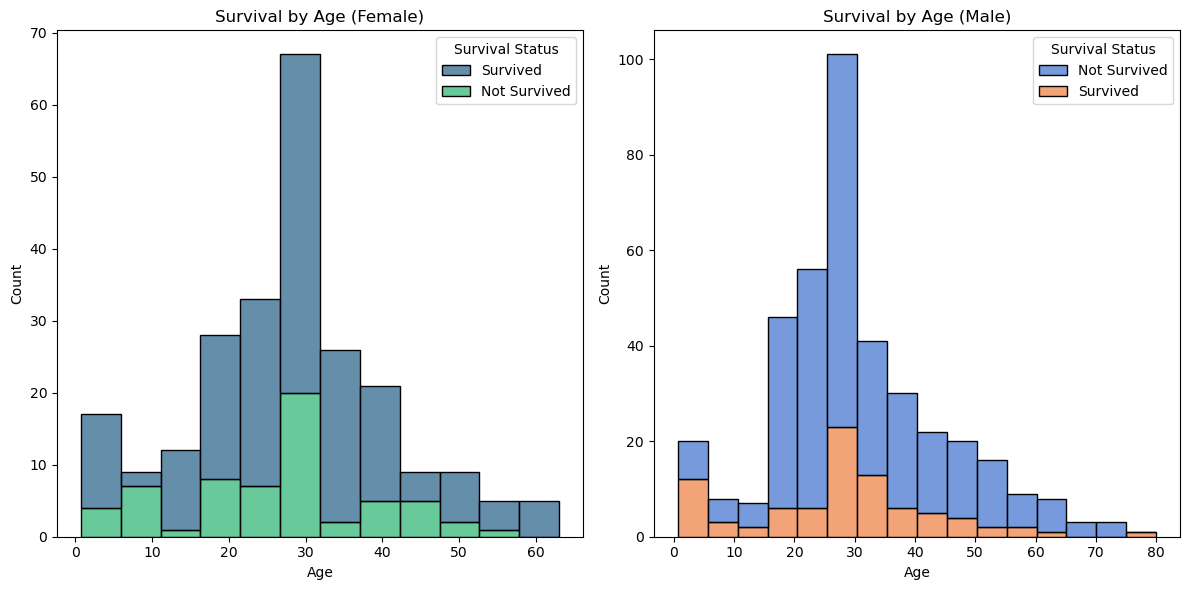

In [424]:
#CELL11  תצוגה של ההישרדות בקרב נשים וגברים לפי גילאים
train_df['Survival Status'] = train_df['Survived'].map({0: 'Not Survived', 1: 'Survived'})

male_df = train_df[train_df['Sex'] == 1]
female_df = train_df[train_df['Sex'] == 0]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=female_df, x='Age', hue='Survival Status', multiple='stack', palette='viridis', binwidth=5)
plt.title('Survival by Age (Female)')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(data=male_df, x='Age', hue='Survival Status', multiple='stack', palette='muted', binwidth=5)
plt.title('Survival by Age (Male)')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Part 3 - Experiments
You could add as many code cells as needed

In [466]:
#CELL 12

# טעינת נתוני האימון והפרדתם למשתנים (X) ותגיות המטרה (y).
train_df = pd.read_csv('titanic_train.csv')
X = train_df.drop(columns='Survived')  # תכונות
y = train_df['Survived']  # משתנה המטרה (האם הנוסע שרד או לא)

# הגדרת עמודות מספריות וקטגוריאליות לעיבוד.
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# טרנספורמטור לעיבוד משתנים מספריים: השלמת ערכים חסרים ונרמול.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # השלמת ערכים חסרים עם הממוצע
    ('scaler', StandardScaler())  # נרמול
])

# טרנספורמטור לעיבוד משתנים קטגוריאליים: השלמת ערכים חסרים והמרה לקטגוריות.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # השלמת ערכים חסרים עם הערך הנפוץ ביותר
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # המרה לקטגוריות
])

# שילוב הטרנספורמטורים לעיבוד כולל של כל העמודות.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),  # עיבוד משתנים מספריים
        ('cat', categorical_transformer, categorical_features)  # עיבוד משתנים קטגוריאליים
    ]
)

# חלוקת הנתונים למערך אימון (train) ומערך אימות (validation).
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# יישום העיבוד על מערך האימון והתיקוף.
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# הצגת ממדי מערכי הנתונים לאחר העיבוד.
print("Shape of processed train data:", X_train_processed.shape)
print("Shape of processed validation data:", X_val_processed.shape)


Shape of processed train data: (569, 13)
Shape of processed validation data: (143, 13)


In [468]:
#CELL 13

# הגדרת המודלים לניסויים: KNN ו-Naive Bayes.
models = {
    'KNN': KNeighborsClassifier(),  # מודל K-Nearest Neighbors
    'Naive Bayes': GaussianNB()  # מודל Naive Bayes
}

# הגדרת טווח היפר-פרמטרים לחיפוש עבור מודל KNN.
param_grid_knn = {
    'n_neighbors': [3, 5, 7],  # מספר השכנים שישקלו בקבלת ההחלטה
    'weights': ['uniform', 'distance'],  # משקלות אחידים או תלויי מרחק
    'p': [1, 2]  # מרחק מנהטן (p=1) או אוקלידי (p=2)
}


In [470]:
#CELL 14

# הגדרת המודלים לניסויים: KNN ו-Naive Bayes
models = {
    'KNN': KNeighborsClassifier(),  # מודל K-Nearest Neighbors
    'Naive Bayes': GaussianNB()  # מודל Naive Bayes
}

# הגדרת טווח היפר-פרמטרים לחיפוש עבור מודל KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7],  # מספר השכנים
    'weights': ['uniform', 'distance'],  # סוגי המשקלות
    'p': [1, 2]  # מרחק מנהטן (p=1) או אוקלידי (p=2)
}

# ביצוע Grid Search עם 5-fold cross-validation על מודל ה-KNN
grid_search_knn = GridSearchCV(estimator=models['KNN'], param_grid=param_grid_knn, cv=5, scoring='f1_macro')
grid_search_knn.fit(X_train_processed, y_train)

# ביצוע 5-fold cross-validation עבור מודל Naive Bayes ומדידת ביצועים
nb_scores = cross_val_score(models['Naive Bayes'], X_train_processed, y_train, cv=5, scoring='f1_macro')


In [482]:
#CELL15
results = []

# יצירת רשימה לאחסון תוצאות המודלים

results.append({
    'Model': 'KNN',
    'Best Params': grid_search_knn.best_params_,
    'Best F1-Score': grid_search_knn.best_score_
})

# שמירת התוצאות של מודל Naive Bayes: אין פרמטרים מותאמים, F1-Score ממוצע

results.append({
    'Model': 'Naive Bayes',
    'Best Params': 'Default',
    'Best F1-Score': nb_scores.mean()
})
# המרת התוצאות ל-DataFrame לצורך הצגה

results_df = pd.DataFrame(results)

styled_results = results_df.style \
    .highlight_max(color='lightgreen', subset=['Best F1-Score']) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) \
    .background_gradient(cmap='Blues', subset=['Best F1-Score'])

styled_results


,Model,Best Params,Best F1-Score
0,KNN,"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.781375
1,Naive Bayes,Default,0.616928


         Model                                       Best Params  \
0          KNN  {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}   
1  Naive Bayes                                           Default   

   Best F1-Score  
0       0.781375  
1       0.616928  


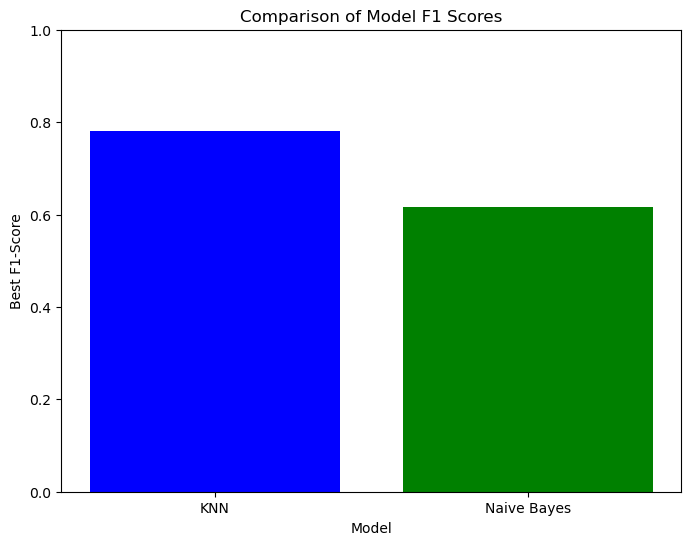

In [436]:
#CELL16
#עוד ויזוליזאציה 
results = []


results.append({
    'Model': 'KNN',
    'Best Params': grid_search_knn.best_params_,
    'Best F1-Score': grid_search_knn.best_score_
})


results.append({
    'Model': 'Naive Bayes',
    'Best Params': 'Default',
    'Best F1-Score': nb_scores.mean()
})


results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['Best F1-Score'], color=['blue', 'green'])
plt.title('Comparison of Model F1 Scores')
plt.xlabel('Model')
plt.ylabel('Best F1-Score')
plt.ylim(0, 1)
plt.show()


In [484]:
#CELL 17

# יצירת אובייקט להוספת תכונות פולינומיות מדרגה שנייה (ללא הטיה)
poly = PolynomialFeatures(degree=2, include_bias=False)

# הוספת תכונות פולינומיות לנתוני האימון המעובדים
X_train_poly = poly.fit_transform(X_train_processed)

# הוספת תכונות פולינומיות לנתוני האימות המעובדים
X_val_poly = poly.transform(X_val_processed)

# הדפסת הצורה (ממדים) של הנתונים המקוריים ושל הנתונים לאחר הוספת התכונות הפולינומיות
print(f"Shape of original train data: {X_train_processed.shape}")
print(f"Shape of train data with polynomial features: {X_train_poly.shape}")


Shape of original train data: (569, 13)
Shape of train data with polynomial features: (569, 104)


In [440]:
#CELL18
grid_search_knn_poly = GridSearchCV(estimator=models['KNN'], param_grid=param_grid_knn, cv=5, scoring='f1_macro')
grid_search_knn_poly.fit(X_train_poly, y_train)
nb_scores_poly = cross_val_score(models['Naive Bayes'], X_train_poly, y_train, cv=5, scoring='f1_macro')
print("Best parameters for KNN with polynomial features:", grid_search_knn_poly.best_params_)
print("Best F1-Score for KNN with polynomial features:", grid_search_knn_poly.best_score_)
print("F1-Score for Naive Bayes with polynomial features:", nb_scores_poly.mean())


Best parameters for KNN with polynomial features: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Best F1-Score for KNN with polynomial features: 0.785097188665415
F1-Score for Naive Bayes with polynomial features: 0.7015831931507222


Original Model Results:
         Model                                       Best Params  \
0          KNN  {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}   
1  Naive Bayes                                           Default   

   Best F1-Score  
0       0.781375  
1       0.616928  

Model Results with Polynomial Features:
                         Model  \
0          KNN (Poly Features)   
1  Naive Bayes (Poly Features)   

                                        Best Params  Best F1-Score  
0  {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}       0.785097  
1                                           Default       0.701583  


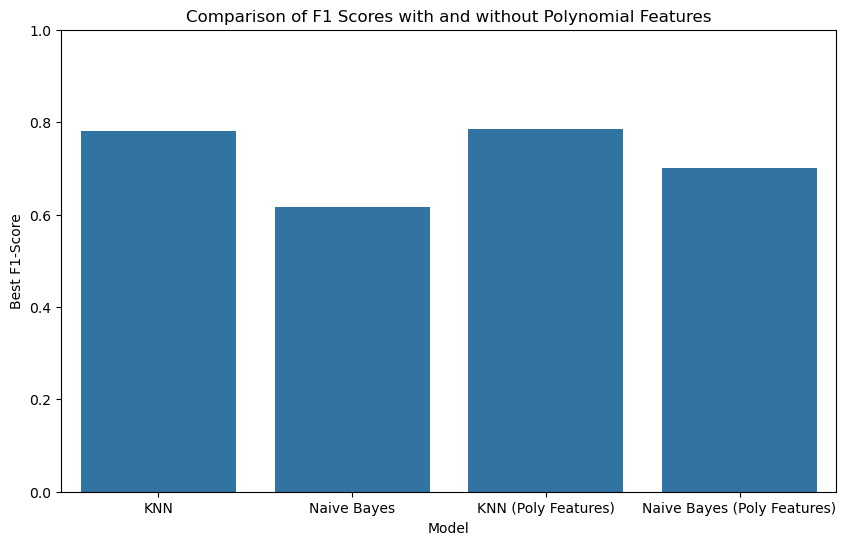

In [441]:
#CELL19

#הצגת התוצאות
results_poly = []


results_poly.append({
    'Model': 'KNN (Poly Features)',
    'Best Params': grid_search_knn_poly.best_params_,
    'Best F1-Score': grid_search_knn_poly.best_score_
})


results_poly.append({
    'Model': 'Naive Bayes (Poly Features)',
    'Best Params': 'Default',
    'Best F1-Score': nb_scores_poly.mean()
})


results_poly_df = pd.DataFrame(results_poly)


print("Original Model Results:")
print(results_df)

print("\nModel Results with Polynomial Features:")
print(results_poly_df)


combined_results = pd.concat([results_df, results_poly_df])

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Best F1-Score', data=combined_results)
plt.title('Comparison of F1 Scores with and without Polynomial Features')
plt.ylabel('Best F1-Score')
plt.ylim(0, 1)
plt.show()

In [486]:
#CELL 20

# הגדרת המודלים לניסויים: KNN ו-Random Forest
models = {
    'KNN': KNeighborsClassifier(),  # מודל K-Nearest Neighbors
    'Random Forest': RandomForestClassifier(random_state=42)  # מודל Random Forest עם seed קבוע
}

# הגדרת טווח היפר-פרמטרים לחיפוש עבור מודל KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7],  # מספר השכנים שיילקחו בחשבון
    'weights': ['uniform', 'distance']  # סוגי המשקלות: אחידים או תלויי מרחק
}

# הגדרת טווח היפר-פרמטרים לחיפוש עבור מודל Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # מספר העצים ביער
    'max_depth': [None, 10, 20]  # עומק העצים (ללא הגבלה, עומק 10, עומק 20)
}


In [488]:
# Perform grid search for KNN using 5-fold cross-validation
grid_search_knn = GridSearchCV(estimator=models['KNN'], param_grid=param_grid_knn, cv=5, scoring='f1_macro')
grid_search_knn.fit(X_train_processed, y_train)

# Perform grid search for Random Forest using 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=models['Random Forest'], param_grid=param_grid_rf, cv=5, scoring='f1_macro')
grid_search_rf.fit(X_train_processed, y_train)

# Display best parameters and scores for KNN and Random Forest
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best F1-Score for KNN:", grid_search_knn.best_score_)
print("\nBest parameters for Random Forest:", grid_search_rf.best_params_)
print("Best F1-Score for Random Forest:", grid_search_rf.best_score_)

Best parameters for KNN: {'n_neighbors': 3, 'weights': 'uniform'}
Best F1-Score for KNN: 0.7813753703626706

Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}
Best F1-Score for Random Forest: 0.8038883029785623


Model Comparison Results:
           Model                               Best Params  Best F1-Score
0            KNN  {'n_neighbors': 3, 'weights': 'uniform'}       0.781375
1  Random Forest    {'max_depth': 10, 'n_estimators': 100}       0.803888


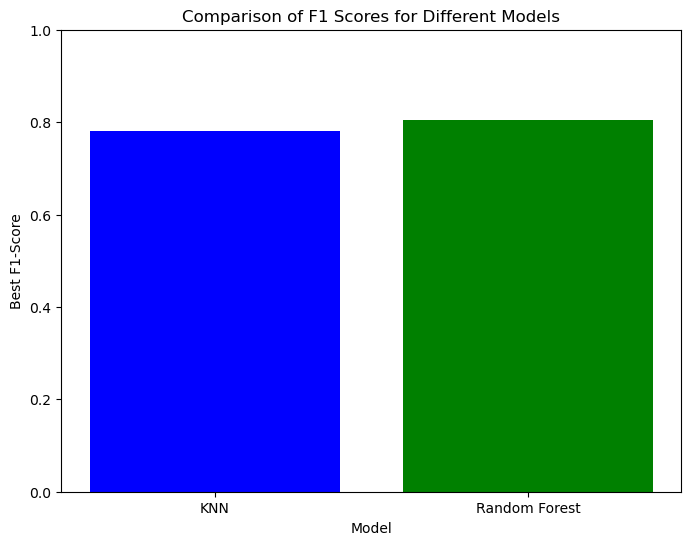

In [492]:
#CELL21
#הצגת התוצאות
results_models = []


results_models.append({
    'Model': 'KNN',
    'Best Params': grid_search_knn.best_params_,
    'Best F1-Score': grid_search_knn.best_score_
})


results_models.append({
    'Model': 'Random Forest',
    'Best Params': grid_search_rf.best_params_,
    'Best F1-Score': grid_search_rf.best_score_
})

results_models_df = pd.DataFrame(results_models)


print("Model Comparison Results:")
print(results_models_df)


plt.figure(figsize=(8, 6))
plt.bar(results_models_df['Model'], results_models_df['Best F1-Score'], color=['blue', 'green'])
plt.title('Comparison of F1 Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('Best F1-Score')
plt.ylim(0, 1)
plt.show()

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [497]:
#CELL 22

# עיבוד כל מערך הנתונים המלא של האימון באמצעות ה-Pipeline שהוגדר
X_train_full = preprocessor.fit_transform(X)

# הצגת ממדי מערך הנתונים לאחר העיבוד
print("Shape of the processed full train data:", X_train_full.shape)


Shape of the processed full train data: (712, 13)


In [499]:
#CELL 23

# יצירת המודל הסופי של Random Forest עם ההיפר-פרמטרים הטובים ביותר שנמצאו ב-Grid Search
best_rf_model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)

# אימון המודל על כל מערך הנתונים המלא של האימון
best_rf_model.fit(X_train_full, y)

# הודעה שהאימון הושלם בהצלחה
print("Training complete with the best model and hyperparameters.")


Training complete with the best model and hyperparameters.


In [503]:
#CELL 24

# עיבוד מערך האימות (validation) באמצעות אותו preprocessor כמו בנתוני האימון
X_val_full = preprocessor.transform(X_val)

# יצירת תחזיות על מערך האימות בעזרת המודל המאומן
val_predictions = best_rf_model.predict(X_val_full)

# חישוב והדפסת מדד ה-F1 עבור נתוני האימות
from sklearn.metrics import classification_report, f1_score
print("Validation F1-Score:", f1_score(y_val, val_predictions, average='macro'))

# הצגת דוח ביצועים מלא הכולל precision, recall, ו-F1 score עבור כל קטגוריה
print("\nClassification Report on Validation Set:\n", classification_report(y_val, val_predictions))


Validation F1-Score: 0.9208473808685151

Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.89      0.99      0.93        79
           1       0.98      0.84      0.91        64

    accuracy                           0.92       143
   macro avg       0.93      0.92      0.92       143
weighted avg       0.93      0.92      0.92       143



## Part 5 - Apply on test and show model performance estimation

In [505]:
#CELL 25

# טעינת נתוני ה-test מקובץ CSV
test_df = pd.read_csv('titanic_test.csv')

# עיבוד נתוני ה-test באמצעות אותו preprocessor ששימש לנתוני האימון והאימות
X_test_processed = preprocessor.transform(test_df)

# הצגת ממדי מערך נתוני ה-test לאחר העיבוד
print("Shape of the processed test data:", X_test_processed.shape)


Shape of the processed test data: (179, 13)


In [388]:
#CELL26
test_predictions = best_rf_model.predict(X_test_processed)


print("First 5 predictions on the test set:", test_predictions[:5])


First 5 predictions on the test set: [0 0 0 1 1]


In [389]:
#CELL27
print("Validation F1-Score (used as test set indicator):", f1_score(y_val, val_predictions, average='macro'))


Validation F1-Score (used as test set indicator): 0.9208473808685151


In [507]:
#CELL 28

# יצירת עותק של נתוני ה-test והוספת עמודת התחזיות של המודל
results_df = test_df.copy()
results_df['Predicted Survived'] = test_predictions  # הוספת תחזיות המודל

# בדיקה אם קיימת עמודת 'Survived' בנתוני ה-test (תוויות אמיתיות)
if 'Survived' in results_df.columns:

    # המרת הערכים המספריים בתוויות המודל והתוויות האמיתיות לתוויות מילוליות
    results_df['Predicted Survived'] = results_df['Predicted Survived'].map({0: 'Not Survived', 1: 'Survived'})
    results_df['True Survived'] = results_df['Survived'].map({0: 'Not Survived', 1: 'Survived'})
    
    # יצירת עמודה המציינת אם התחזית הייתה נכונה או לא
    results_df['Correct Prediction'] = results_df['Predicted Survived'] == results_df['True Survived']
    
    # חישוב דיוק המודל באחוזים
    accuracy = results_df['Correct Prediction'].mean() * 100
    print(f"Model Accuracy: {accuracy:.2f}%")  # הצגת הדיוק

    # הצגת עמודות נבחרות להשוואת התחזיות והתוצאות האמיתיות
    columns_to_display = ['Pclass', 'Sex', 'Age', 'True Survived', 'Predicted Survived', 'Correct Prediction']
    final_results_df = results_df[columns_to_display]
    pd.set_option('display.max_rows', None)  # הצגת כל השורות בטבלה
    display(final_results_df)  # הצגת התוצאות
    
else:
  
    print(".")


Model Accuracy: 88.27%


,Pclass,Sex,Age,True Survived,Predicted Survived,Correct Prediction
0,3,1,35.000000,Not Survived,Not Survived,True
1,3,1,30.000000,Not Survived,Not Survived,True
2,3,1,29.699118,Not Survived,Not Survived,True
3,3,0,21.000000,Not Survived,Survived,False
4,3,1,32.000000,Survived,Survived,True
5,1,1,17.000000,Survived,Not Survived,False
6,3,0,21.000000,Not Survived,Not Survived,True
7,3,1,9.000000,Not Survived,Not Survived,True
8,1,0,52.000000,Survived,Survived,True
9,3,1,29.699118,Not Survived,Not Survived,True
